In [158]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits, ascii

# Plot formatting
plt.rc('text', usetex=True)
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed
mpl.rcParams['axes.formatter.use_mathtext'] = True

# Convert files

In [2]:
raw_spectra_dir = "/Users/adamboesky/Research/long_transients/Data/followup/spectra/raw"
filenames = os.listdir(raw_spectra_dir)
filenames

['85_210p82_19p294.fits',
 'SPECTRUMspec1d_ccd0123c1-AT6352p55n25p80_LDSS3_20250626_coadded_tellcorr.ascii',
 '38_222p85_21p040.fits',
 'AT2025adamtar_FLEET_LDSS3c_2025.0302.txt',
 'SPECTRUMspec1d_ccd0130c1-AT14355p63n27p83_LDSS3_20250626_coadded_tellcorr.ascii',
 '112_227p82_19p622.fits']

In [3]:
raw_fnames = [
    '85_210p82_19p294.fits',
    'SPECTRUMspec1d_ccd0123c1-AT6352p55n25p80_LDSS3_20250626_coadded_tellcorr.ascii',
    '38_222p85_21p040.fits',
    'AT2025adamtar_FLEET_LDSS3c_2025.0302.txt',
    'SPECTRUMspec1d_ccd0130c1-AT14355p63n27p83_LDSS3_20250626_coadded_tellcorr.ascii',
    '112_227p82_19p622.fits'
]
filtered_fnames = [
    '85_210p82_19p294.txt',
    '6_352p55_25p80.txt',
    '38_222p85_21p040.txt',
    '31_221p68_17p961.txt',
    '14_355p63_27p83.txt',
    '112_227p82_19p622.txt'
]

In [153]:
def convert_file(raw_name, filtered_name):
    raw_path = os.path.join(raw_spectra_dir, raw_name)
    filtered_path = os.path.join('/Users/adamboesky/Research/long_transients/Data/followup/spectra', filtered_name)

    # Read the raw file
    if raw_name.endswith('.fits'):
        hdu_temp = fits.open(raw_path)
        spec = hdu_temp[0].data
        header = hdu_temp[0].header

        # Construct wavelength array
        wavelengths = header['CRVAL1'] + header['CD1_1'] * np.arange(spec.shape[-1])

        # Extract and scale flux
        flux = np.nan_to_num(spec[0, :])  # assume single spectrum in multi-extension FITS
        flux /= 1e-17  # Convert to 10^-17 erg / cm^2 / s / Å

        data = np.column_stack([wavelengths, flux])
        hdu_temp.close()

    elif raw_name.endswith('.txt'):
        with open(raw_path, 'r') as f:
            lines = f.readlines()
        data = np.genfromtxt(lines)

    elif raw_name.endswith('.ascii'):
        data = ascii.read(raw_path)
        data = np.array(data)
        data = data.view(np.float64).reshape(-1, 2)

    # Format data
    data = data[np.argsort(data[:,0])]

    # Custom stuff
    if raw_name == 'AT2025adamtar_FLEET_LDSS3c_2025.0302.txt':
        data = data[(data[:, 0] / 2.7) > 1475]
        data = data[(data[:, 0] / 2.7) < 3750]

    # Write the filtered file (no flux conversion for .txt/.ascii yet)
    np.savetxt(filtered_path, data, fmt='%.6f')

    return data

In [154]:
spectra_data = []
for raw_name, filtered_name in zip(raw_fnames, filtered_fnames):
    spectra_data.append(convert_file(raw_name, filtered_name))

# Plot

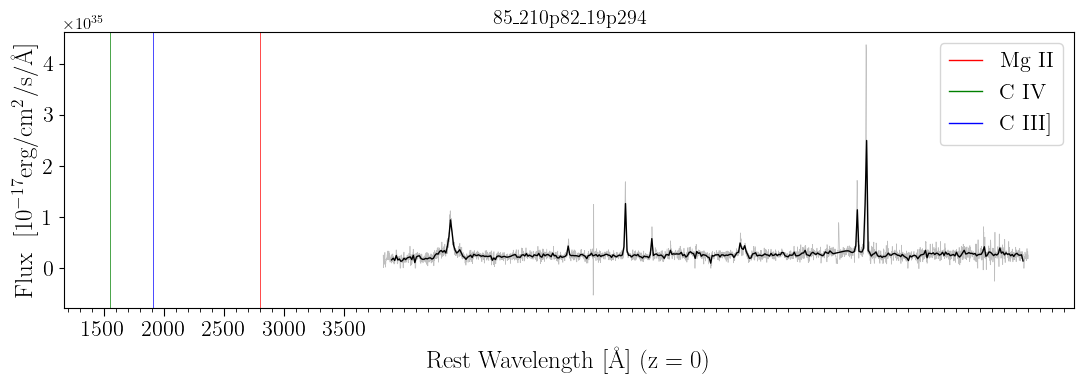

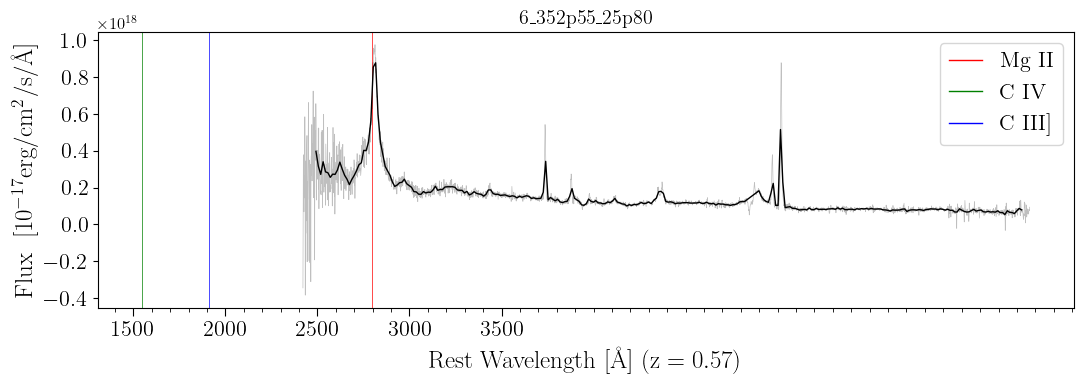

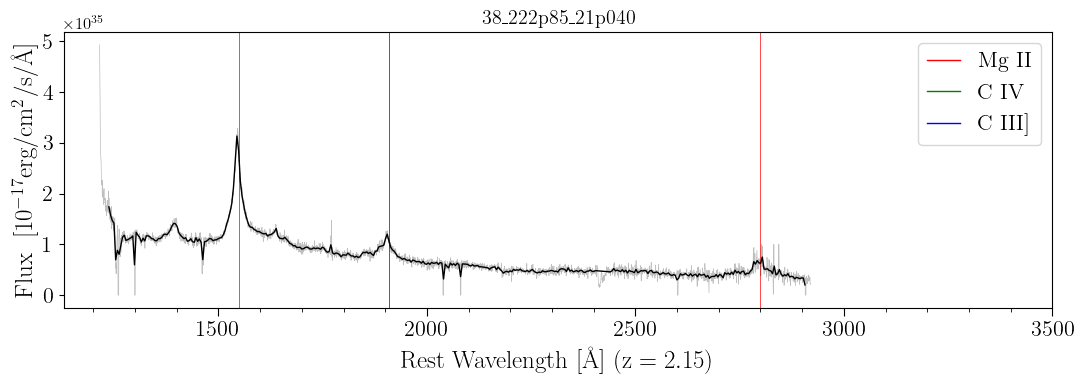

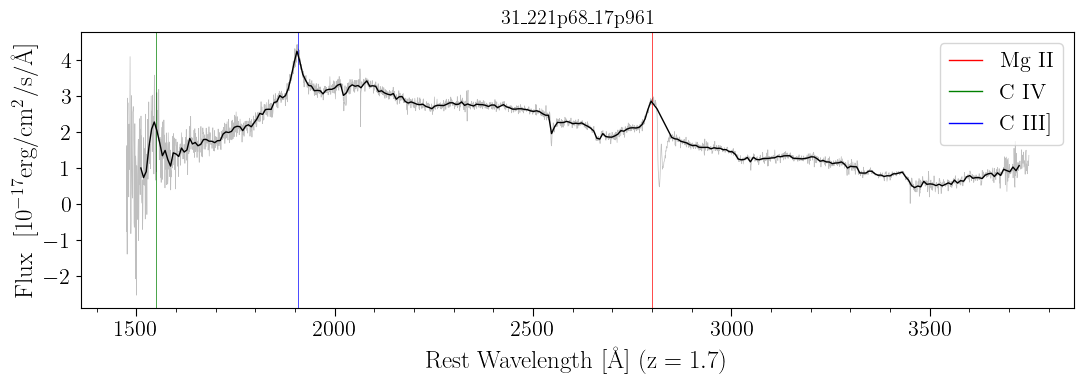

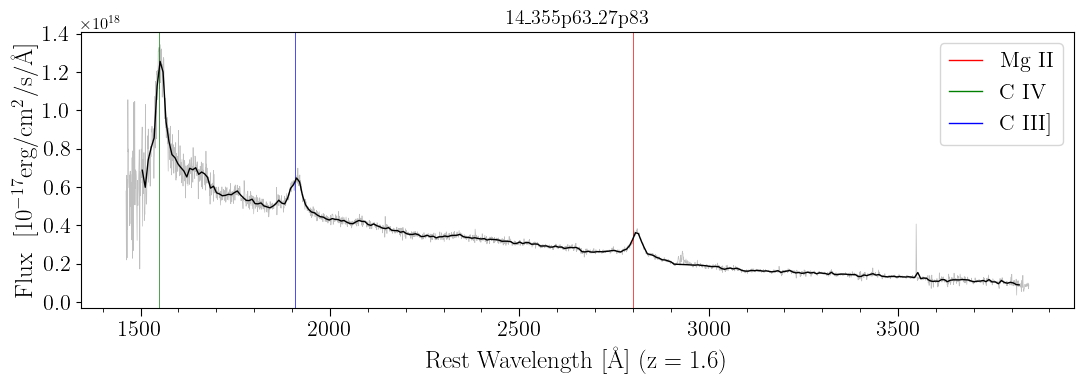

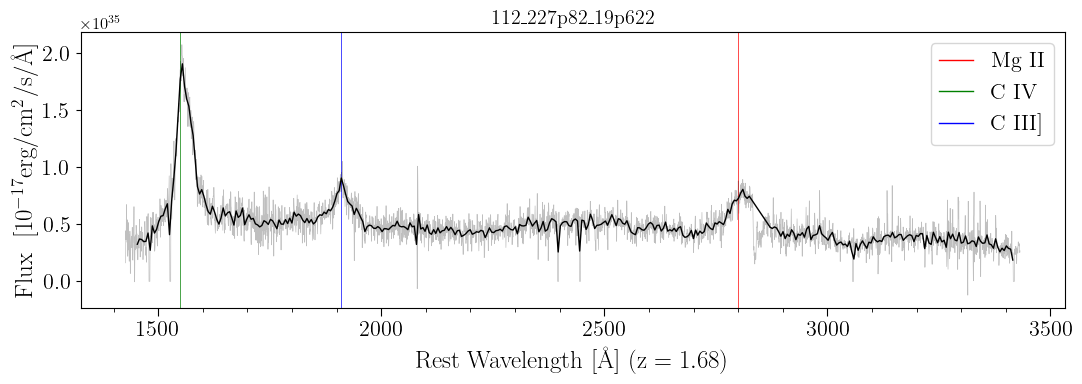

In [160]:
# Example plotting code for all spectra in spectra_data

# Example metadata for plotting; replace with actual values as needed
names     = filtered_fnames
redshifts = [0, 0.57, 2.15, 1.7, 1.6, 1.68]
ylims     = [np.nanmax(data[:,1])*1.1 if isinstance(data, np.ndarray) and data.ndim > 1 else 5.0 for data in spectra_data]

def bin_spectra(wavelength, flux, binsize):
    """Simple binning function for spectra."""
    n_bins = len(wavelength) // binsize
    wavelength_bin = np.mean(wavelength[:n_bins * binsize].reshape(-1, binsize), axis=1)
    flux_bin = np.mean(flux[:n_bins * binsize].reshape(-1, binsize), axis=1)
    return wavelength_bin, flux_bin

for object_name, data, redshift, y_lim in zip(names, spectra_data, redshifts, ylims):

    plt.figure(figsize=(11, 4))

    # Import Data
    # data may be astropy Table or numpy array
    if hasattr(data, 'colnames'):
        # astropy Table
        arr = np.array(data)
        wavelength = arr[:,0]
        flux = arr[:,1]
        sigma = arr[:,2] if arr.shape[1] > 2 else np.zeros_like(flux)
    else:
        # numpy array
        wavelength = data[:,0]
        flux = data[:,1]
        sigma = data[:,2] if data.shape[1] > 2 else np.zeros_like(flux)

    # Bin Data
    # Remove telluric region if in optical
    good = (wavelength > 7580) & (wavelength < 7680)
    mask = ~good
    # Avoid edge effects
    if np.sum(mask) > 70:
        w_bin, f_bin = bin_spectra(wavelength[mask][50:-20], flux[mask][50:-20], 10)
    else:
        w_bin, f_bin = bin_spectra(wavelength, flux, 10)

    # Plot reference lines
    plt.axvline(x = 2799.117, color = 'red', linewidth = 0.5, zorder = -1, label = 'Mg II')
    plt.axvline(x = 1549.48, color = 'green', linewidth = 0.5, zorder = -1, label = 'C IV')
    plt.axvline(x = 1908.734, color = 'blue', linewidth = 0.5, zorder = -1, label = 'C III]')
    # plt.axvline(x = 5183.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5172.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5167.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 2803.000, color = 'r'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 4958.911, color = 'k'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5006.843, color = 'k'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'O')
    # plt.axvline(x = 6562.760, color = 'b'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 4861.327, color = 'b'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'H')
    # plt.axvline(x = 4686.000, color = 'orange', linewidth = 1, alpha = 0.5, linestyle = '--', label = 'He II')
    # plt.axvline(x = 3968.500, color = 'c'     , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 3933.700, color = 'c'     , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'Ca')
    # plt.axvline(x = 5889.950, color = 'pink'  , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 5895.924, color = 'pink'  , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'Na')
    # plt.axvline(x = 6548.000, color = 'gray'  , linewidth = 1, alpha = 0.5, linestyle = '--')
    # plt.axvline(x = 6584.000, color = 'gray'  , linewidth = 1, alpha = 0.5, linestyle = '--', label = 'NII')


    leg = plt.legend(loc='upper right', fontsize=16, handlelength=1.5)
    for legobj in leg.legend_handles:
        legobj.set_linewidth(1.0)

    plt.plot(wavelength / (1 + redshift), flux * 1E17, color = 'k', linewidth = 0.5, alpha = 0.25)
    plt.plot(w_bin / (1 + redshift), f_bin * 1E17, color = 'k', linewidth = 1)

    # plt.xlim(1475, 3750)
    # plt.ylim(0, y_lim)

    plt.xlabel(fr'Rest Wavelength [\AA] ($\rm{{z}} = {redshift}$)', fontsize = 18)
    plt.ylabel(r'Flux \ [$10^{-17}$erg/cm$^2$/s/\AA]', fontsize = 18)
    plt.xticks(np.arange(1500, 3800, 500), fontsize=16)
    plt.yticks(fontsize=16)
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(100))
    plt.tick_params(axis='x', which='major', length=6)
    plt.tick_params(axis='x', which='minor', length=3)

    plt.title(object_name.split('.')[0])

    plt.tight_layout()

    # Save to Figures directory
    plt.savefig(f'/Users/adamboesky/Research/long_transients/Data/followup/spectra/plots/{object_name}_spectrum.pdf', bbox_inches='tight')

    plt.show()